<a href="https://colab.research.google.com/github/ziadelsharawy/Test/blob/main/Final_project_Deep_learning(penomia).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chest X-Ray Images (Pneumonia)




##What does Pneumonia mean?

Pneumonia is a medical condition characterized by inflammation of the air sacs in one or both lungs. These air sacs, known as alveoli, can become filled with fluid or pus, leading to symptoms such as cough with phlegm, fever, chills, and difficulty breathing. Pneumonia can be caused by various microorganisms, including bacteria, viruses, and fungi.

Common symptoms of pneumonia include:

1. Cough, often producing phlegm
2. Fever
3. Shortness of breath
4. Chest pain, particularly when breathing or coughing
5. Fatigue
6. Sweating
7. Bluish discoloration of the lips or nails (in severe cases)

Pneumonia can range from mild to severe and may require medical attention, especially in vulnerable populations such as the elderly, young children, or individuals with weakened immune systems. Treatment typically involves antibiotics for bacterial pneumonia or antiviral medications for viral pneumonia. Supportive care, including rest, hydration, and sometimes hospitalization, may be necessary depending on the severity of the condition.


##The difference between normal and Pneumonia in X-Ray Images
Normal
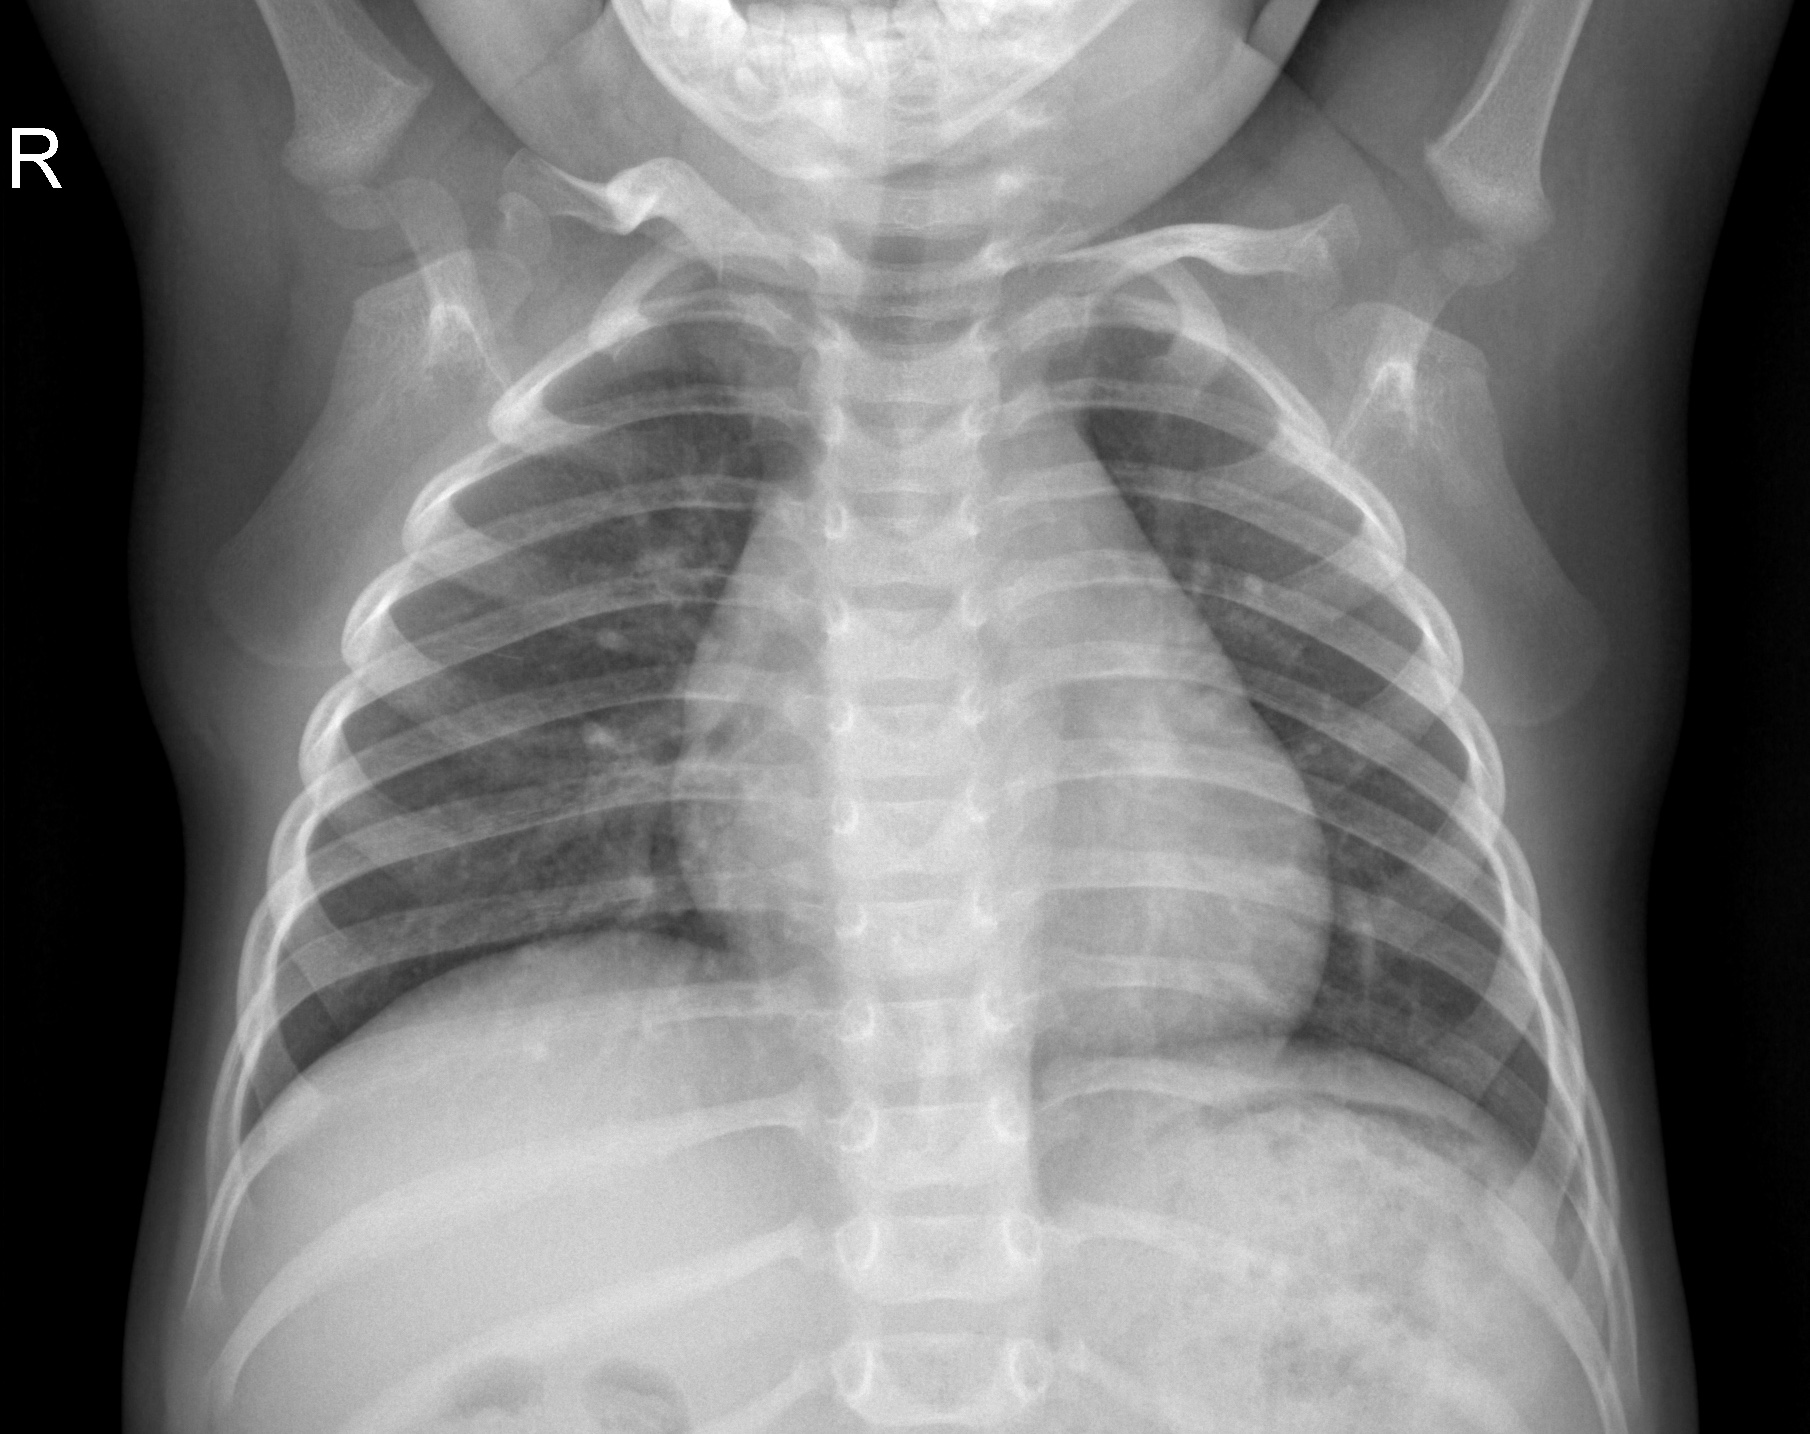
Pneumonia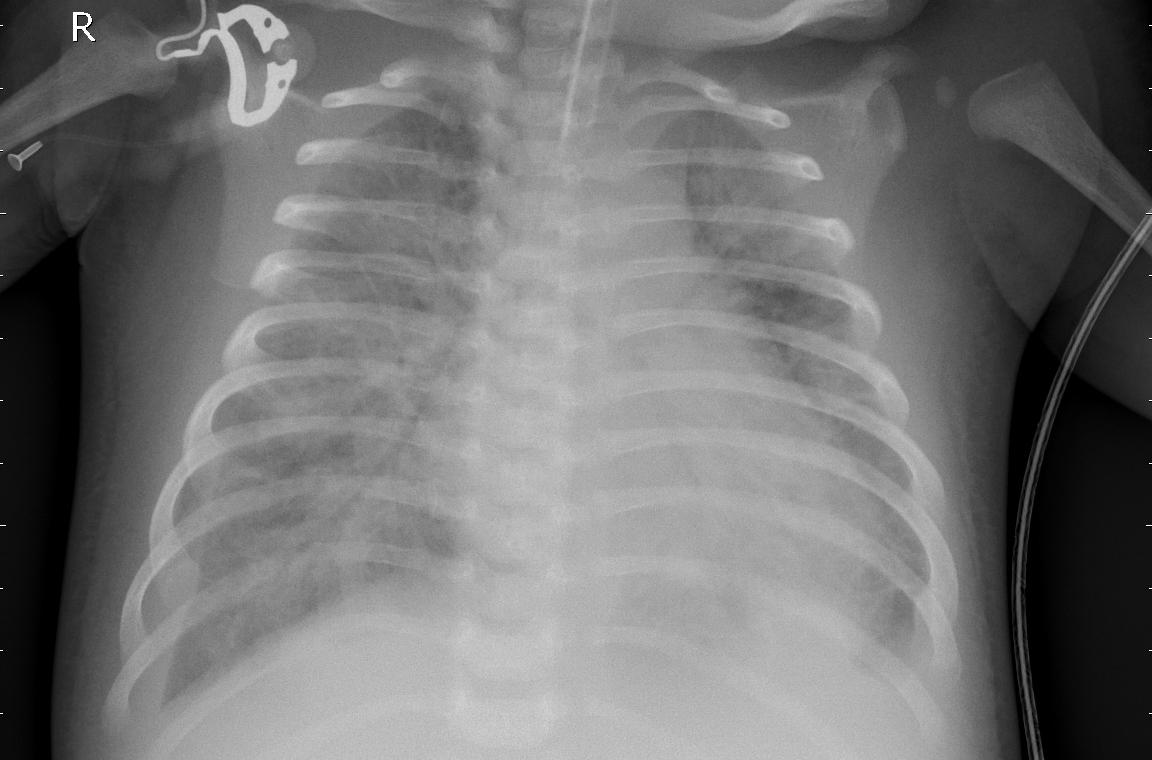

# Code

In [ ]:
!pip install opendatasets

## Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import opendatasets as od
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

## load data

In [ ]:
#{"username":"ziadelsharawy","key":"2d86fd42e7bababf81c2fe173d4e74a6"}
data = od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ziadelsharawy
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:46<00:00, 53.2MB/s]


##Visualization data

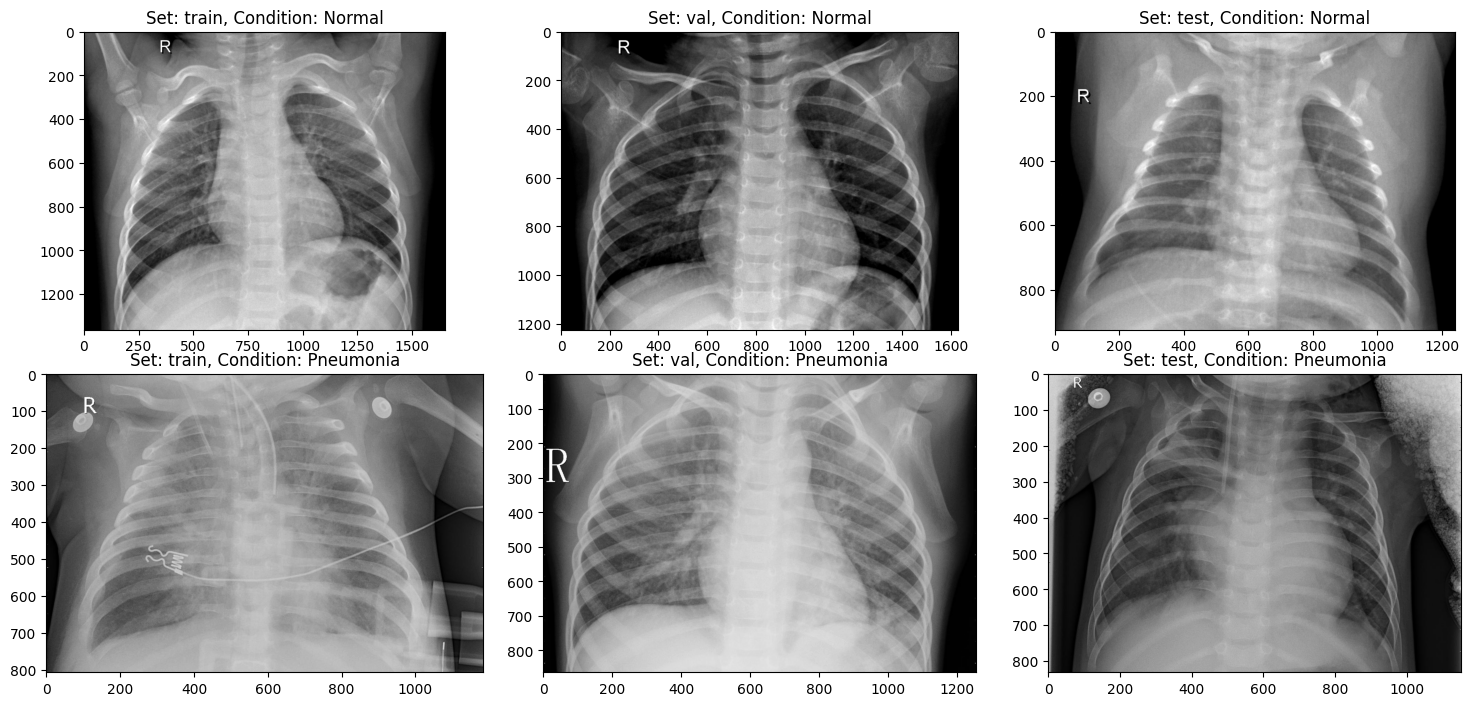

In [ ]:
input_path = "/content/chest-xray-pneumonia/chest_xray/chest_xray/"

fig ,ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout() #To expand distances

for i,t_data in enumerate(['train', 'val', 'test']):
    data_path = input_path + t_data
    ax[i].imshow(plt.imread(data_path + '/NORMAL/' + os.listdir(data_path + '/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(t_data))
    ax[i+3 ].imshow(plt.imread(data_path + '/PNEUMONIA/' + os.listdir(data_path + '/PNEUMONIA')[0]), cmap='gray')
    ax[i+3 ].set_title('Set: {}, Condition: Pneumonia'.format(t_data))



##count data normal and pneumonia and path t_data




In [ ]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_pneumonia = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal,n_pneumonia))


Set: train, normal images: 1342, pneumonia images: 3876
Set: val, normal images: 9, pneumonia images: 9
Set: test, normal images: 234, pneumonia images: 390


In [ ]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)

    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
        directory=input_path + 'train',
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    test_gen = test_val_datagen.flow_from_directory(
        directory=input_path + 'test',
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path + 'test' + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond == '/NORMAL/':
                label = 0
            elif cond == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)



    return train_gen, test_gen, test_data, test_labels


In [ ]:
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 32)        9248      
                                                             

In [ ]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size,
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

<ipython-input-16-1556081dfae9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/10
163/163 [==============================] - 693s 4s/step - loss: 0.8240 - accuracy: 0.7504 - val_loss: 1.3047 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 671s 4s/step - loss: 0.3826 - accuracy: 0.8376 - val_loss: 1.0207 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.3326 - accuracy: 0.8614
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 678s 4s/step - loss: 0.3326 - accuracy: 0.8614 - val_loss: 0.6927 - val_accuracy: 0.7270 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 658s 4s/step - loss: 0.2317 - accuracy: 0.9078 - val_loss: 5.2324 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - 673s 4s/step - loss: 0.2217 - accuracy: 0.9162 - val_loss: 2.6312 - val_accuracy: 0.6266 - lr: 3.0000e-04
Epoch 6/10
163/163 [==============================]

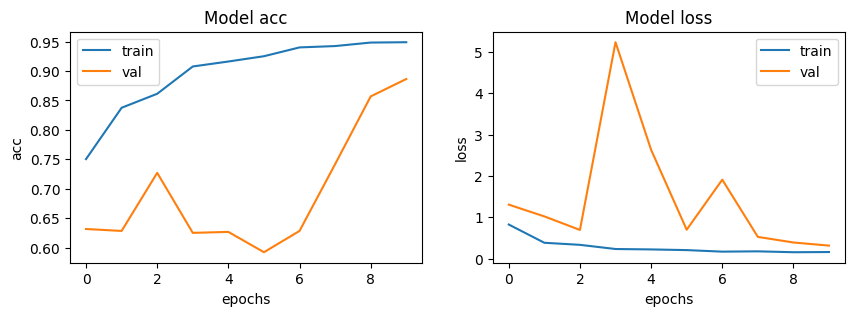

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    # Check if the key 'acc' exists, otherwise check for 'accuracy'
    if met in hist.history:
        ax[i].plot(hist.history[met])
    elif 'accuracy' in hist.history:
        ax[i].plot(hist.history['accuracy'])
    else:
        raise KeyError(f'Neither {met} nor accuracy found in training history')

    # Similarly, check for 'val_acc' or 'val_accuracy'
    val_met = 'val_' + met
    if val_met in hist.history:
        ax[i].plot(hist.history[val_met])
    elif 'val_accuracy' in hist.history:
        ax[i].plot(hist.history['val_accuracy'])
    else:
        raise KeyError(f'Neither {val_met} nor val_accuracy found in training history')

    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


In [ ]:
# Convert lists to numpy arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Evaluate the model using the formatted test data and labels
loss, accuracy = model.evaluate(test_data, test_labels)

print("Loss of the model is - ", loss)
print("Accuracy of the model is - ", accuracy * 100, "%")


20/20 [==============================] - 16s 805ms/step - loss: 0.3185 - accuracy: 0.8830
Loss of the model is -  0.318484902381897
Accuracy of the model is -  88.30128312110901 %


In [ ]:
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes[:15])


20/20 [==============================] - 15s 703ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
from sklearn.metrics import classification_report

# Assuming predictions is a continuous probability output
# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Ensure that test_labels are in the appropriate format
# Then use classification_report
print(classification_report(test_labels, predicted_classes, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.38      1.00      0.55       234
   Normal (Class 1)       0.00      0.00      0.00       390

           accuracy                           0.38       624
          macro avg       0.19      0.50      0.27       624
       weighted avg       0.14      0.38      0.20       624



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def predict_image(model, img_path, img_dims):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB for compatibility with Matplotlib
    img = cv2.resize(img, (img_dims, img_dims))
    img = np.expand_dims(img, axis=0) / 255.0  # Normalize the image

    prediction = model.predict(img)
    predicted_class = 'NORMAL' if prediction[0][0] < 0.5 else 'PNEUMONIA'

    plt.imshow(img[0], cmap='gray')  # Display the image in grayscale
    plt.title(f"Predicted: {predicted_class}")
    plt.show()
    return predicted_class


In [ ]:
model.load_weights('best_weights.hdf5')

1/1 [==============================] - 0s 82ms/step


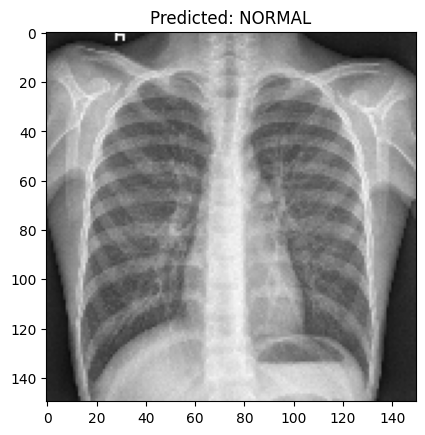

Predicted class: NORMAL


In [ ]:
sample_image_path = '/content/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0007-0001.jpeg'  # Replace with your image path
predicted_class = predict_image(model, sample_image_path, img_dims)
print("Predicted class:", predicted_class)


1/1 [==============================] - 0s 79ms/step


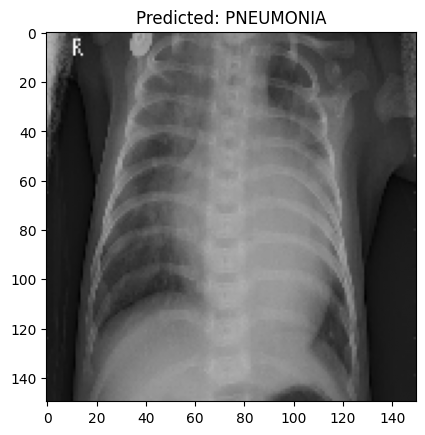

Predicted class: PNEUMONIA


In [ ]:
sample_image_path = '/content/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/person133_bacteria_633.jpeg'  # Replace with your image path
predicted_class = predict_image(model, sample_image_path, img_dims)
print("Predicted class:", predicted_class)